<a href="https://colab.research.google.com/github/Rez99/Experimentation/blob/main/Sequential_Testing_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
if (!requireNamespace("tictoc", quietly = TRUE)) {
  install.packages("tictoc")
}
if (!requireNamespace("gsDesign", quietly = TRUE)) {
  install.packages("gsDesign")
}
library(tidyverse)
library(tictoc)
library(gsDesign)
library(MASS)

|      | Efficacy Only | Futility Only | Efficacy + Futility |
|----------|----------|----------|----------|
| Design ref. test|

|      | Efficacy Only | Futility Only | Efficacy + Futility |
|----------|----------|----------|----------|
| Design ref. test|
| $H_{0}$    | 1. Find z1, z2 boundaries that deliver $\alpha$ = 0.05     | 1. Set any z1 futility boundary<br>2. Find z2 boundary that delivers $\alpha$ = 0.05      | 1. Set any z1 futility boundary<br>2. Find z1, z2 boundaries that deliver $\alpha$ = 0.05     |
| $H_{1}$    | Find center of distribution ($n$) that delivers $\beta$ = 0.2     | Find center of distribution ($n$) that delivers $\beta$ = 0.2     | Find center of distribution ($n$) that delivers $\beta$ = 0.2     |
| Max. $n$|1.12|1.04|1.07
| Mean $n: H_{0}$|1.104|0.701|0.710
| Mean $n: H_{1}$|0.844|1.000 (the majority end at n=1.04)|0.845
| Mean relative bias: $H_{0}$|1.29|0.97|1.15
| Mean relative bias: $H_{1}$|1.11|0.99|1.10





# 0 Create distribution

In [ ]:
# set parameters
alpha <- 0.05
beta <- 0.2
delta <- 5
k <- 1
n_fix <- 1000

# compute z scores
z_one_minus_alpha <- qnorm(p = 1-alpha, mean = 0, sd = 1)
z_beta <- qnorm(p = beta, mean = 0, sd = 1)
print('Compute combined z value')
z_combo <- z_one_minus_alpha - z_beta
z_combo

[1] "Compute combined z value"


[1] 2.486475

In [ ]:
set.seed(1)

n <- 1e6
rho <- 1 / sqrt(2)  # correlation between z1 and z2

Sigma <- matrix(c(1, rho,
                  rho, 1), nrow = 2)

z_scores_h0 <- MASS::mvrnorm(n = n, mu = c(0, 0), Sigma = Sigma) |>
  as_tibble(.name_repair = "unique_quiet") |>
  setNames(c("z1", "z2"))

glimpse(z_scores_h0)

Rows: 1,000,000
Columns: 2
$ z1 <dbl> -0.6899603, 0.4846576, -0.3701514, 1.2361713, 0.3445685, -0.6994212…
$ z2 <dbl> -0.46757544, -0.14532896, -1.17388892, 1.71152329, 0.26428245, -0.8…


# 1 Efficacy Only

## Design test

[1] 1.875423 1.875423

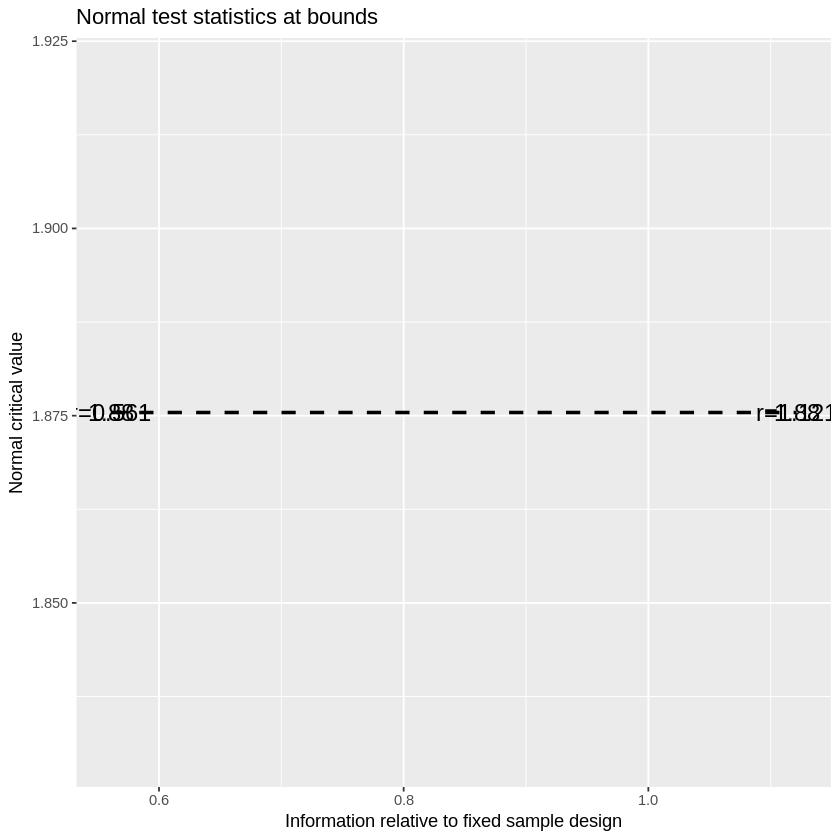

In [ ]:
d <- gsDesign(
    k = 2,
    alpha = 0.05,
    beta = 0.2,
    test.type = 1,
    sfu="Pocock"
    )

plot(d)
d$upper$bound

## $H_{0}$

- BLUE: Proportion of data points falling in the BLUE region represents the Type I error spent at the first interim analysis (peek 1).

- RED: Proportion of data points falling in the RED region represents the Type I error spent at the second and final analysis (peek 2).

Together, these regions account for the total Type I error (alpha) of 0.05.

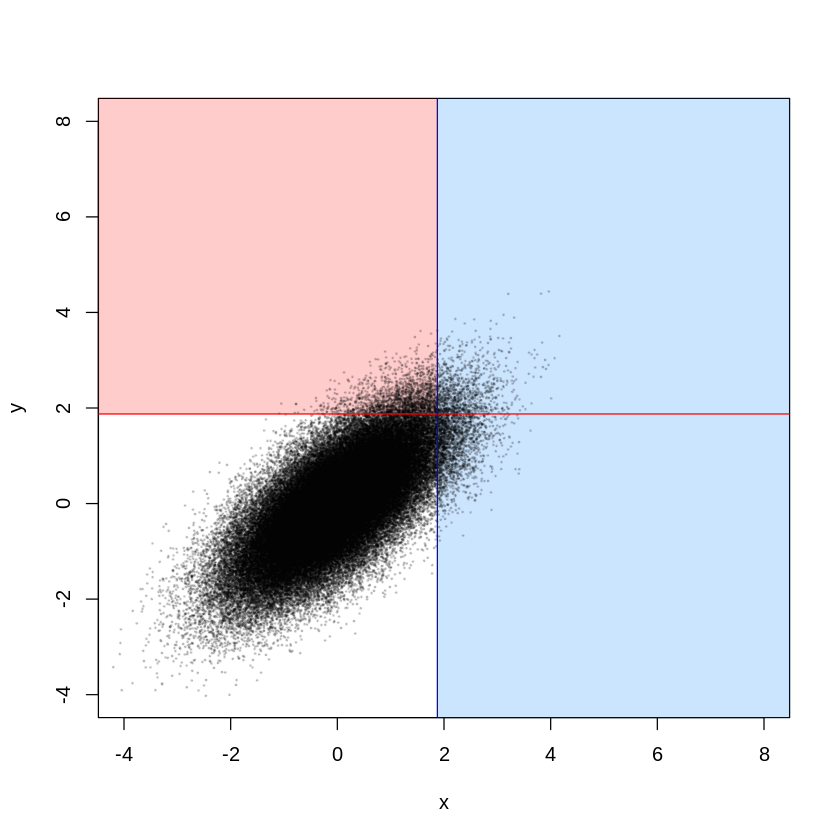

In [ ]:
# @title
# Sample points
pts <- z_scores_h0 |> sample_n(1e5)
x <- pts[[1]]
y <- pts[[2]]

# Use appropriate bounds
z1 <- d$upper$bound[1]  # threshold for x
z2 <- d$upper$bound[2]  # threshold for y

# Set desired x and y limits
xlim_vals <- c(-4, 8)
ylim_vals <- c(-4, 8)

# Create blank canvas with custom limits
plot(x, y, type = "n", xlim = xlim_vals, ylim = ylim_vals)


# Shade x >= z1
rect(
  xleft = z1, ybottom = par("usr")[3],
  xright = par("usr")[2], ytop = par("usr")[4],
  col = rgb(0, 0.5, 1, 0.2), border = NA
)

# Red: region where y ≥ z2 AND x < z1
rect(
  xleft = par("usr")[1], ybottom = z2,
  xright = z1, ytop = par("usr")[4],
  col = rgb(1, 0, 0, 0.2), border = NA
)




# Plot points
points(x, y, pch = 20, cex = 0.3, col = rgb(0, 0, 0, 0.15))


abline(h = z1, col = rgb(1, 0, 0, 1), lwd = 1)
abline(v = z2, col = rgb(0, 0, 1, 1), lwd = 1)

In [ ]:
print('Verify alpha')
z_scores_h0 |>
  summarise(mean(z1 > d$upper$bound[1] | z2 > d$upper$bound[1])) |>
  pull()

[1] "Verify alpha"


[1] 0.050026

## $H_{1}$

In [ ]:
b <- sqrt(d$n.I[2]) * z_combo

z_scores_h1 <- z_scores_h0 |>
    transmute(
      z1 = z1 + b / sqrt(2),
      z2 = z2 + b
    )

print('Verify β')
z_scores_h1 |>
  summarise(mean(z1 < d$upper$bound[1] & z2 < d$upper$bound[1])) |>
  pull()

[1] "Verify β"


[1] 0.200196

- BLUE: Proportion of data points falling in the BLUE region represents the probability of crossing the efficacy boundary at the first interim analysis (peek 1) under the alternative hypothesis (i.e., early stopping for success).

- RED: Proportion of data points falling in the RED region represents the probability of crossing the efficacy boundary at the final analysis (peek 2) under the alternative hypothesis.

Together, these regions account for the overall power of the design.

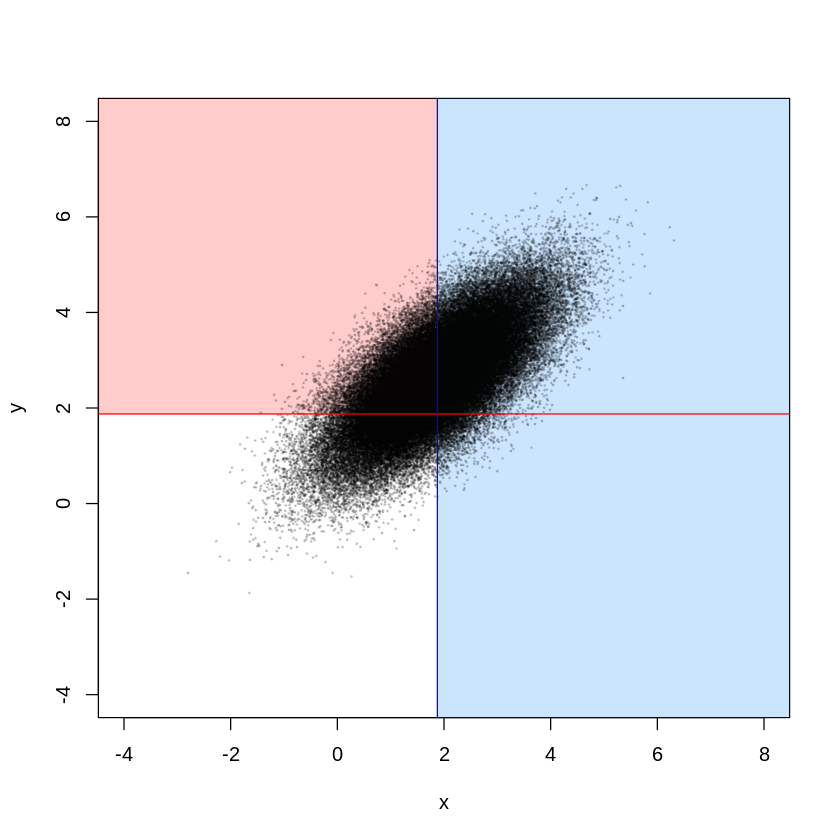

In [ ]:
# @title
# Sample points
pts <- z_scores_h1 |> sample_n(1e5)
x <- pts[[1]]
y <- pts[[2]]

# Use appropriate bounds
z1 <- d$upper$bound[1]  # threshold for x
z2 <- d$upper$bound[2]  # threshold for y

# Set desired x and y limits
xlim_vals <- c(-4, 8)
ylim_vals <- c(-4, 8)

# Create blank canvas with custom limits
plot(x, y, type = "n", xlim = xlim_vals, ylim = ylim_vals)


# Shade x >= z1
rect(
  xleft = z1, ybottom = par("usr")[3],
  xright = par("usr")[2], ytop = par("usr")[4],
  col = rgb(0, 0.5, 1, 0.2), border = NA
)

# Red: region where y ≥ z2 AND x < z1
rect(
  xleft = par("usr")[1], ybottom = z2,
  xright = z1, ytop = par("usr")[4],
  col = rgb(1, 0, 0, 0.2), border = NA
)

# Plot points
points(x, y, pch = 20, cex = 0.3, col = rgb(0, 0, 0, 0.15))

abline(h = z1, col = rgb(1, 0, 0, 1), lwd = 1)
abline(v = z2, col = rgb(0, 0, 1, 1), lwd = 1)

## Max $n$, mean $n$

In [ ]:
print('Maximum n scaling factor')
d$n.I[2]
print('Expected sample size accounting for early stopping')
d$en

[1] "Maximum n scaling factor"


[1] 1.121168

[1] "Expected sample size accounting for early stopping"


[1] 1.1041449 0.8439502

## Bias

Relative to fixed sample test:

\begin{align}
z & = \frac{\delta}{SE}  \\
\\
z & = \frac{\delta}{\sqrt{\frac{\sigma^2}{n}+\frac{\sigma^2}{kn}}}  \\
\text{Assume } k,\, \sigma \text{ are constant:}\\
\delta & \propto \frac{z}{\sqrt{n}}  \\
\\
\frac{\delta_{seq}}{\delta_{fix}} & = \frac{\left(\frac{z}{\sqrt{n}}\right)_{seq}}{\left(\frac{z}{\sqrt{n}}\right)_{fix}} \\
\left(\frac{z}{\sqrt{n}}\right)_{seq} & = \text{weighted avg.}\left(\left(\frac{z}{\sqrt{n}}\right)_{peek_1},\left(\frac{z}{\sqrt{n}}\right)_{peek_2}\right) \\
\left(\frac{z}{\sqrt{n}}\right)_{fix} & = \left(\frac{z}{\sqrt{n}}\right)_{peek_2}
\end{align}

### $H_{0}$

In [ ]:
#set.seed(1)
#a <- rnorm(n=1e6, mean = 0, sd = 1)
#b <- rnorm(n=1e6, mean = 10, sd = 1)

#c <- a %>% as_tibble() %>% arrange(value) %>% tail(-2e5) %>% pull()
#d <- b %>% as_tibble() %>% arrange(value) %>% tail(-2e5) %>% pull()

#mean(b)-mean(a)
#mean(d)-mean(c)

In [ ]:
# z/√n fix
print('Blue points')
blue_points <- z_scores_h0 |> filter(z2 > z_one_minus_alpha)

wins_2 <-  blue_points |> nrow()
z_2 <- blue_points |> pull(z2) |> mean()
n_2 <- 1

wins_2
z_2
n_2

print('Weighted z/√n fix')
z_n_fix <- z_2 / sqrt(n_2)
z_n_fix

[1] "Blue points"


[1] 50022

[1] 2.061425

[1] 1

[1] "Weighted z/√n fix"


[1] 2.061425

In [ ]:
# z/√n seq

print('Blue points')
blue_points <- z_scores_h0 |> filter(z1 > d$upper$bound[1])
wins_1 <-  blue_points |> nrow()
z_1 <- blue_points |> pull(z1) |> mean()
n_1 <- d$n.I[1]
wins_1
z_1
n_1

print('Red points')
red_points <- z_scores_h0 |> filter(z1 < d$upper$bound[1] & z2 > d$upper$bound[1])
wins_2 <- red_points |> nrow()
z_2 <- red_points |> pull(z2) |> mean()
n_2 <- d$n.I[2]
wins_2
z_2
n_2

print('Weighted z/√n seq')
z_n_seq <- wins_1 / (wins_1 + wins_2) * (z_1 / sqrt(n_1)) + wins_2 / (wins_1 + wins_2) * (z_2 / sqrt(n_2))
z_n_seq

[1] "Blue points"


[1] 30505

[1] 2.259944

[1] 0.5605841

[1] "Red points"


[1] 19521

[1] 2.194318

[1] 1.121168

[1] "Weighted z/√n seq"


[1] 2.649239

In [ ]:
print('relative_bias')
relative_bias <- z_n_seq / z_n_fix
relative_bias

[1] "relative_bias"


[1] 1.28515

In [ ]:
gsBoundSummary(d)

,Analysis,Value,Efficacy
,<chr>,<chr>,<dbl>
1,IA 1: 50%,Z,1.8754
3,N/Fixed design N: 0.56,p (1-sided),0.0304
5,,~delta at bound,1.0074
13,,P(Cross) if delta=0,0.0304
15,,P(Cross) if delta=1,0.4945
2,Final,Z,1.8754
4,N/Fixed design N: 1.12,p (1-sided),0.0304
6,,~delta at bound,0.7123
14,,P(Cross) if delta=0,0.0500


### $H_{1}$

In [ ]:
b <- sqrt(1) * z_combo

z_scores_h1_fix <- z_scores_h0 |>
    transmute(
      z1 = z1 + b / sqrt(2),
      z2 = z2 + b
    )


In [ ]:
# z/√n fix
print('Blue points')
blue_points <- z_scores_h1_fix |> filter(z2 > z_one_minus_alpha)

wins_2 <-  blue_points |> nrow()
z_2 <- blue_points |> pull(z2) |> mean()
n_2 <- 1

wins_2
z_2
n_2

print('Weighted z/√n fix')
z_n_fix <- z_2 / sqrt(n_2)
z_n_fix

[1] "Blue points"


[1] 799690

[1] 2.837096

[1] 1

[1] "Weighted z/√n fix"


[1] 2.837096

In [ ]:
# z/√n seq

print('Blue points')
blue_points <- z_scores_h1 |> filter(z1 > d$upper$bound[1])
wins_1 <-  blue_points |> nrow()
z_1 <- blue_points |> pull(z1) |> mean()
n_1 <- d$n.I[1]
wins_1
z_1
n_1

print('Red points')
red_points <- z_scores_h1 |> filter(z1 < d$upper$bound[1] & z2 > d$upper$bound[1])
wins_2 <- red_points |> nrow()
z_2 <- red_points |> pull(z2) |> mean()
n_2 <- d$n.I[2]
wins_2
z_2
n_2

print('Weighted z/√n seq')
z_n_seq <- wins_1 / (wins_1 + wins_2) * (z_1 / sqrt(n_1)) + wins_2 / (wins_1 + wins_2) * (z_2 / sqrt(n_2))
z_n_seq

[1] "Blue points"


[1] 494308

[1] 2.668943

[1] 0.5605841

[1] "Red points"


[1] 305496

[1] 2.604568

[1] 1.121168

[1] "Weighted z/√n seq"


[1] 3.142649

In [ ]:
print('relative_bias')
relative_bias <- z_n_seq / z_n_fix
relative_bias

[1] "relative_bias"


[1] 1.107699

# 2 Futility Only

## Design test

[1] 1.296088

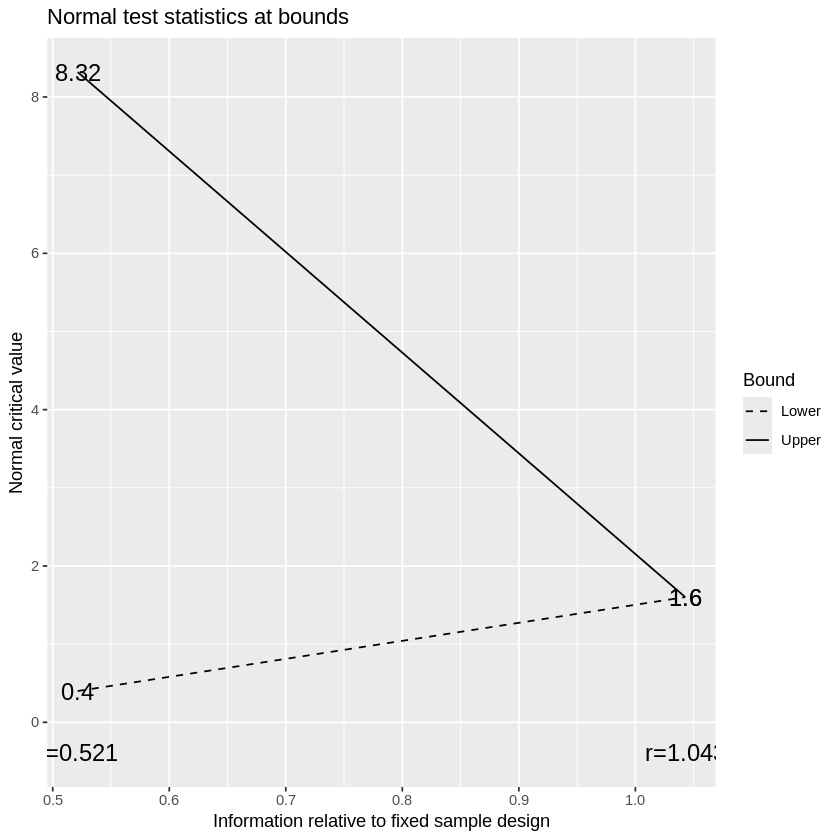

In [ ]:
# @title
# Specifiy futilty boundary
gdDesign_optimize_fun <- function(var) {
  target <- 0.4
  d <- gsDesign(
    k = 2,
    alpha = 0.05,
    beta = 0.2,
    test.type = 3,
    sfu = sfPower,
    sfupar = 50,
    sfl = sfPower,
    sflpar = var
  )
  d$lower$bound[1] - target
}

result <- uniroot(
  function(var) gdDesign_optimize_fun(var),
  interval = c(0.1, 5),
  tol = 1e-15
)

result$root

d <- gsDesign(    k = 2,
    alpha = 0.05,
    beta = 0.2,
    test.type = 3,
    sfu=sfPower,
    sfupar = 50,
    sfl=sfPower,
    sflpar=result$root)

plot(d)

## $H_{0}$

- YELLOW: Proportion of data points in the YELLOW region represents the probability of crossing the futility boundary at the first interim analysis (peek 1) under the null hypothesis (i.e., early stopping for futility).

- RED: Proportion of data points in the RED region represents the Type I error at the final analysis (peek 2), which defines the overall alpha level of 0.05.
Together, these regions account for the total Type I error (alpha) of 0.05.

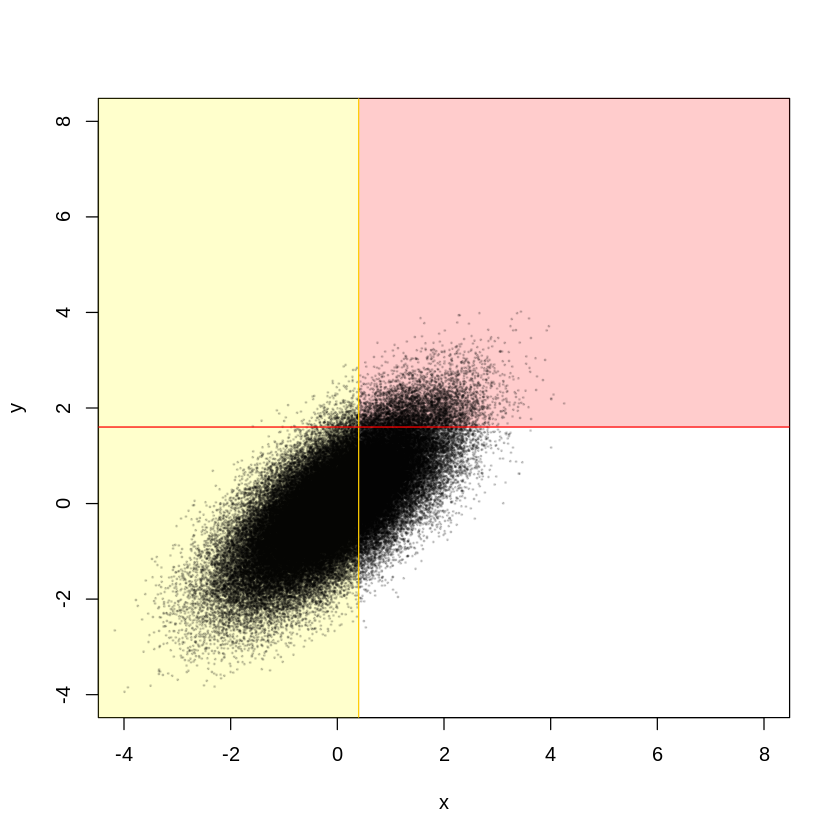

In [ ]:
# @title
# Sample points
pts <- z_scores_h0 |> sample_n(1e5)
x <- pts[[1]]
y <- pts[[2]]

# Use appropriate bounds
z1 <- d$lower$bound[1]  # threshold for x
z2 <- d$upper$bound[2]

# Set desired x and y limits
xlim_vals <- c(-4, 8)
ylim_vals <- c(-4, 8)

# Create blank canvas with custom limits
plot(x, y, type = "n", xlim = xlim_vals, ylim = ylim_vals)


# Shade x >= z1
rect(
  xleft = par("usr")[1],  # far left of plot
  xright = z1,            # up to z1
  ybottom = par("usr")[3],
  ytop = par("usr")[4],
  col = rgb(1, 1, 0, 0.2),
  border = NA
)

# Red: region where y ≥ z2 AND x ≥ z1
rect(
  xleft = z1, ybottom = z2,
  xright = par("usr")[2], ytop = par("usr")[4],
  col = rgb(1, 0, 0, 0.2), border = NA
)





# Plot points
points(x, y, pch = 20, cex = 0.3, col = rgb(0, 0, 0, 0.15))
abline(v = z1, col = rgb(1, 0.8, 0, 1), lwd = 1)
abline(h = z2, col = rgb(1, 0, 0, 1), lwd = 1)

In [ ]:
print('Verify alpha')
z_scores_h0 |>
  summarise(mean(z1 > d$lower$bound[1] & z2 > d$upper$bound[2])) |>
  pull()

[1] "Verify alpha"


[1] 0.050114

In [ ]:
d$lower$bound[1]
d$upper$bound[2]

[1] 0.4

[1] 1.601861

## $H_{1}$

In [ ]:
b <- sqrt(d$n.I[2]) * z_combo

z_scores_h1 <- z_scores_h0 |>
    transmute(
      z1 = z1 + b / sqrt(2),
      z2 = z2 + b
    )

print('Verify β')
z_scores_h1 |>
  summarise(mean(z1 < d$lower$bound[1] | z2 < d$upper$bound[2])) |>
  pull()

[1] "Verify β"


[1] 0.20019

- YELLOW: Proportion of data points in the YELLOW region represents early stopping for futility at the first interim analysis (peek 1), contributing to the overall Type II error under the alternative hypothesis.

- WHITE: Proportion of data points in the WHITE region represents failing to reject the null hypothesis at the final analysis (peek 2), also contributing to the overall Type II error.

Together, these regions account for the total Type II error rate (β) of the design.

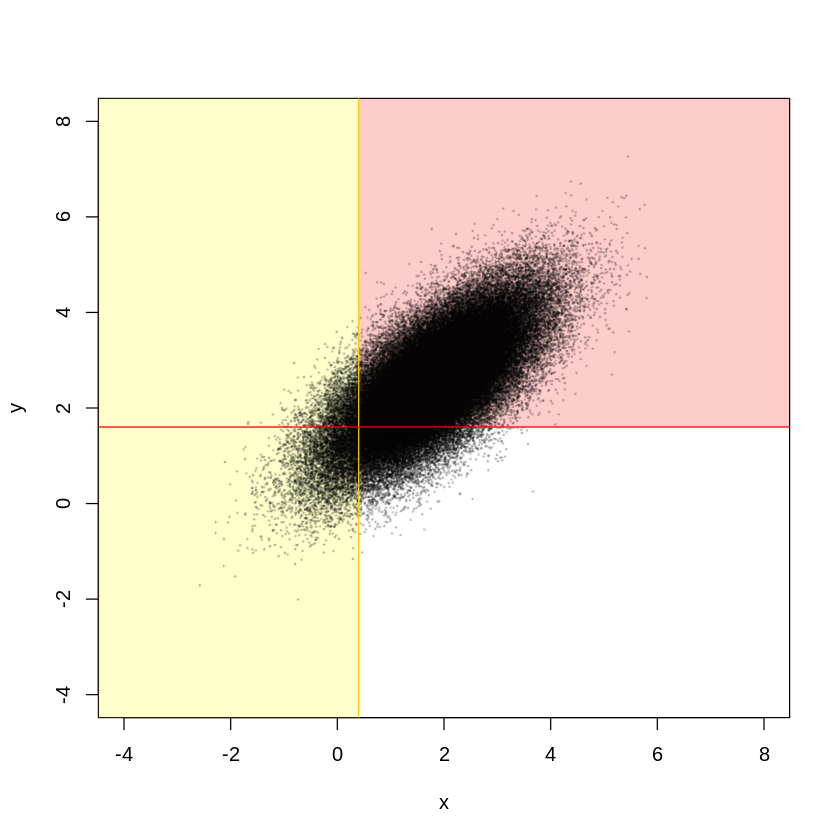

In [ ]:
# @title
# Sample points
pts <- z_scores_h1 |> sample_n(1e5)
x <- pts[[1]]
y <- pts[[2]]

# Use appropriate bounds
z1 <- d$lower$bound[1]  # threshold for x
z2 <- d$upper$bound[2]

# Set desired x and y limits
xlim_vals <- c(-4, 8)
ylim_vals <- c(-4, 8)

# Create blank canvas with custom limits
plot(x, y, type = "n", xlim = xlim_vals, ylim = ylim_vals)


# Shade x >= z1
rect(
  xleft = par("usr")[1],  # far left of plot
  xright = z1,            # up to z1
  ybottom = par("usr")[3],
  ytop = par("usr")[4],
  col = rgb(1, 1, 0, 0.2),
  border = NA
)

# Red: region where y ≥ z2 AND x ≥ z1
rect(
  xleft = z1, ybottom = z2,
  xright = par("usr")[2], ytop = par("usr")[4],
  col = rgb(1, 0, 0, 0.2), border = NA
)





# Plot points
points(x, y, pch = 20, cex = 0.3, col = rgb(0, 0, 0, 0.15))

abline(v = z1, col = rgb(1, 0.8, 0, 1), lwd = 1)
abline(h = z2, col = rgb(1, 0, 0, 1), lwd = 1)

In [ ]:
z_scores_h1 |>
  summarise(mean(z1 < d$lower$bound[1])) |>
  pull()

z_scores_h1 |>
  summarise(mean(z1 > d$lower$bound[1] & z2 < d$upper$bound[2])) |>
  pull()

0.081443 * (1.0427741565939/2) + (1-0.081443) * 1.0427741565939

[1] 0.081443

[1] 0.118747

[1] 1.000311

## Max $n$, mean $n$

In [ ]:
print('Maximum n scaling factor')
d$n.I[2]
print('Expected sample size accounting for early stopping')
d$en

[1] "Maximum n scaling factor"


[1] 1.042774

[1] "Expected sample size accounting for early stopping"


[1] 0.7010457 1.0003094

## Bias

### $H_{0}$

In [ ]:
# z/√n fix
print('Blue points')
blue_points <- z_scores_h0 |> filter(z2 > z_one_minus_alpha)

wins_2 <-  blue_points |> nrow()
z_2 <- blue_points |> pull(z2) |> mean()
n_2 <- 1

wins_2
z_2
n_2

print('Weighted z/√n fix')
z_n_fix <- z_2 / sqrt(n_2)
z_n_fix

[1] "Blue points"


[1] 50022

[1] 2.061425

[1] 1

[1] "Weighted z/√n fix"


[1] 2.061425

In [ ]:
# z/√n seq

print('Red points')
red_points <- z_scores_h0 |> filter(z1 > d$lower$bound[1] & z2 > d$upper$bound[2])
wins_2 <- red_points |> nrow()
z_2 <- red_points |> pull(z2) |> mean()
n_2 <- d$n.I[2]
wins_2
z_2
n_2

print('Weighted z/√n seq')
z_n_seq <- z_2 / sqrt(n_2)
z_n_seq

[1] "Red points"


[1] 50114

[1] 2.03991

[1] 1.042774

[1] "Weighted z/√n seq"


[1] 1.997634

In [ ]:
print('relative_bias')
relative_bias <- z_n_seq / z_n_fix
relative_bias

[1] "relative_bias"


[1] 0.969055

### $H_{1}$

In [ ]:
# z/√n fix
print('Blue points')
blue_points <- z_scores_h1_fix |> filter(z2 > z_one_minus_alpha)

wins_2 <-  blue_points |> nrow()
z_2 <- blue_points |> pull(z2) |> mean()
n_2 <- 1

wins_2
z_2
n_2

print('Weighted z/√n fix')
z_n_fix <- z_2 / sqrt(n_2)
z_n_fix

[1] "Blue points"


[1] 799690

[1] 2.837096

[1] 1

[1] "Weighted z/√n fix"


[1] 2.837096

In [ ]:
# z/√n seq

print('Red points')
red_points <- z_scores_h1 |> filter(z1 > d$lower$bound[1] & z2 > d$upper$bound[2])
wins_2 <- red_points |> nrow()
z_2 <- red_points |> pull(z2) |> mean()
n_2 <- d$n.I[2]
wins_2
z_2
n_2

print('Weighted z/√n seq')
z_n_seq <- z_2 / sqrt(n_2)
z_n_seq

[1] "Red points"


[1] 799810

[1] 2.875777

[1] 1.042774

[1] "Weighted z/√n seq"


[1] 2.816178

In [ ]:
print('relative_bias')
relative_bias <- z_n_seq / z_n_fix
relative_bias

[1] "relative_bias"


[1] 0.9926271

# 3 Efficacy + Futility

## Design test

[1] 1.348559

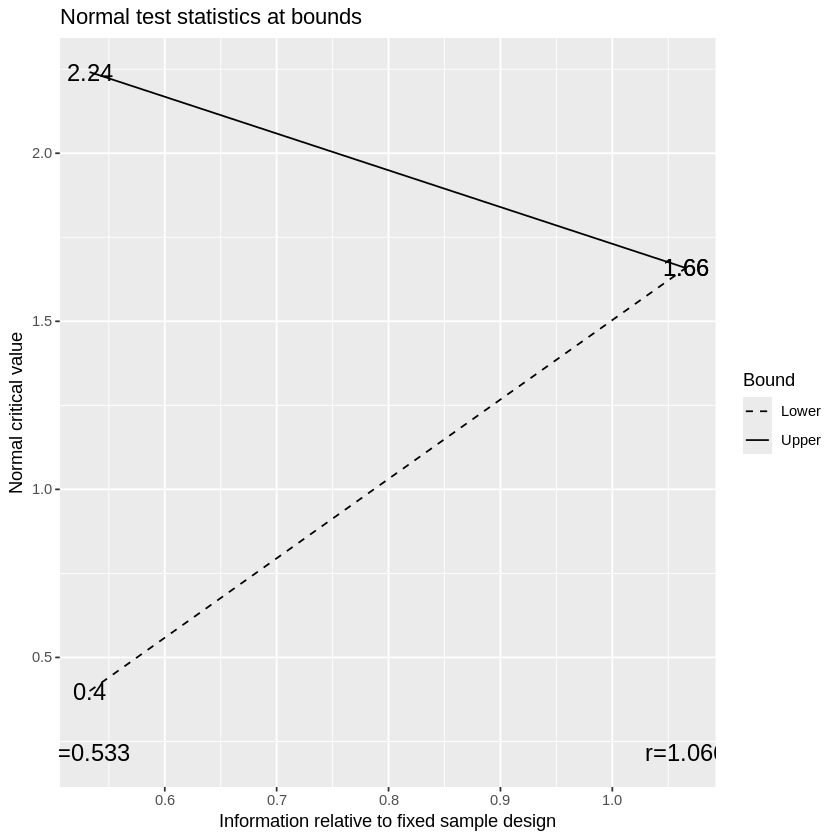

In [ ]:
# @title
# Specifiy futilty boundary
gdDesign_optimize_fun <- function(var) {
  target <- 0.4
  d <- gsDesign(
    k = 2,
    alpha = 0.05,
    beta = 0.2,
    test.type = 3,
    sfu = sfPower,
    sfupar = 2,
    sfl = sfPower,
    sflpar = var
  )
  d$lower$bound[1] - target
}

result <- uniroot(
  function(var) gdDesign_optimize_fun(var),
  interval = c(0.1, 5),
  tol = 1e-15
)

result$root

d <- gsDesign(    k = 2,
    alpha = 0.05,
    beta = 0.2,
    test.type = 3,
    sfu=sfPower,
    sfupar = 2,
    sfl=sfPower,
    sflpar=result$root)

plot(d)

## $H_{0}$

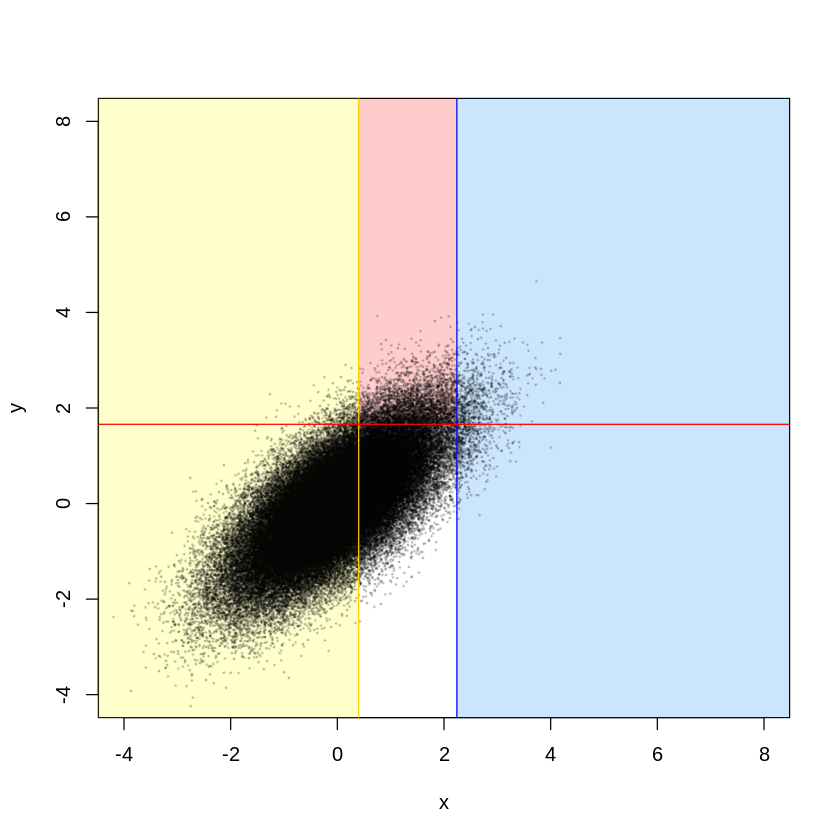

In [ ]:
# @title
# Sample points
pts <- z_scores_h0 |> sample_n(1e5)
x <- pts[[1]]
y <- pts[[2]]

# Use appropriate bounds
z1_f <- d$lower$bound[1]
z1_e <- d$upper$bound[1]
z2_e <- d$upper$bound[2]

# Set desired x and y limits
xlim_vals <- c(-4, 8)
ylim_vals <- c(-4, 8)

# Create blank canvas with custom limits
plot(x, y, type = "n", xlim = xlim_vals, ylim = ylim_vals)

# 1. Yellow: x in (-Inf, z1_f)
rect(
  xleft = par("usr")[1],
  xright = z1_f,
  ybottom = par("usr")[3],
  ytop = par("usr")[4],
  col = rgb(1, 1, 0, 0.2),
  border = NA
)

# 2. Red: x in [z1_f, z1_e), y in [-Inf, z2_e)
rect(
  xleft = z1_f,
  xright = z1_e,
  ybottom = z2_e,
  ytop = par("usr")[4],
  col = rgb(1, 0, 0, 0.2),
  border = NA
)

# 3. Blue: x in [z1_e, +Inf)
rect(
  xleft = z1_e,
  xright = par("usr")[2],
  ybottom = par("usr")[3],
  ytop = par("usr")[4],
  col = rgb(0, 0.5, 1, 0.2),
  border = NA
)


# Plot points on top
points(x, y, pch = 20, cex = 0.3, col = rgb(0, 0, 0, 0.15))

#abline(h = 0, col = rgb(0, 0, 0, 0.2), lty = 2)
#abline(v = 0, col = rgb(0, 0, 0, 0.2), lty = 2)
abline(v = z1_f, col = rgb(1, 0.8, 0, 1), lwd = 1)
abline(v = z1_e, col = rgb(0, 0, 1, 1), lwd = 1)
abline(h = z2_e, col = rgb(1, 0, 0, 1), lwd = 1)

In [ ]:
print('Verify alpha')
z_scores_h0 |>
  summarise(mean(z1 > d$lower$bound[1] & (z1 > d$upper$bound[1] | z2 > d$upper$bound[2]))) |>
  pull()

[1] "Verify alpha"


[1] 0.050059

In [ ]:
d$n.I
d$lower$bound[1]
d$upper$bound[1]
d$upper$bound[2]

[1] 0.5328153 1.0656305

[1] 0.4

[1] 2.241403

[1] 1.658603

## $H_{1}$

In [ ]:
b <- sqrt(d$n.I[2]) * z_combo

z_scores_h1 <- z_scores_h0 |>
    transmute(
      z1 = z1 + b / sqrt(2),
      z2 = z2 + b
    )

print('Verify β')
z_scores_h1 |>
  summarise(mean(z1 < d$lower$bound[1] | (z1 < d$upper$bound[1] & z2 <= d$upper$bound[2]))) |>
  pull()


[1] "Verify β"


[1] 0.200214

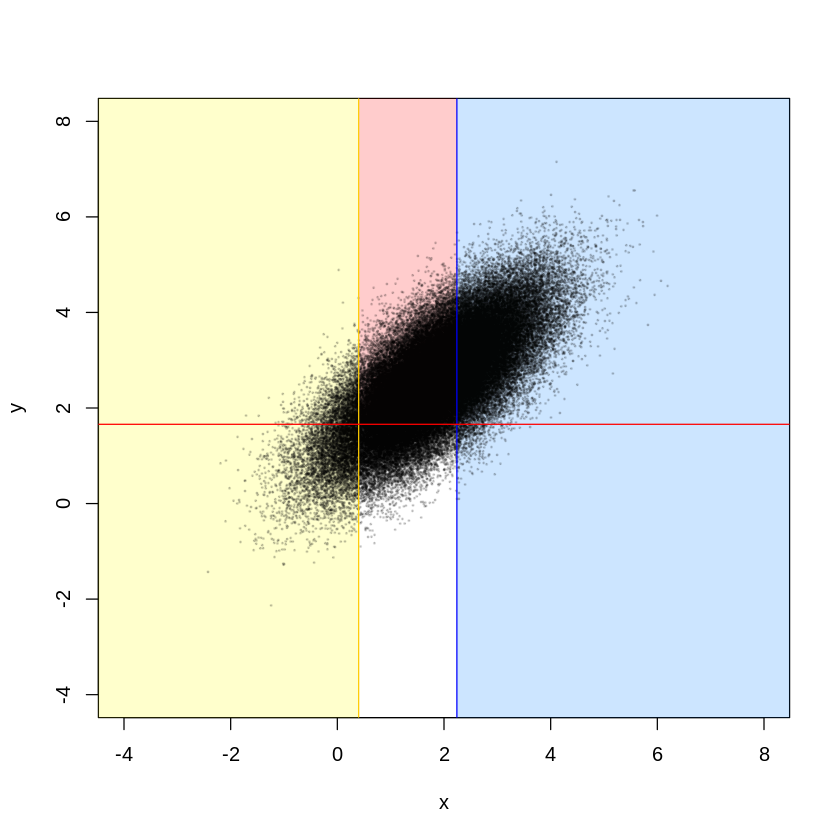

In [ ]:
# @title
# Sample points
pts <- z_scores_h1 |> sample_n(1e5)
x <- pts[[1]]
y <- pts[[2]]

# Use appropriate bounds
z1_f <- d$lower$bound[1]
z1_e <- d$upper$bound[1]
z2_e <- d$upper$bound[2]

# Set desired x and y limits
xlim_vals <- c(-4, 8)
ylim_vals <- c(-4, 8)

# Create blank canvas with custom limits
plot(x, y, type = "n", xlim = xlim_vals, ylim = ylim_vals)

# 1. Yellow: x in (-Inf, z1_f)
rect(
  xleft = par("usr")[1],
  xright = z1_f,
  ybottom = par("usr")[3],
  ytop = par("usr")[4],
  col = rgb(1, 1, 0, 0.2),
  border = NA
)

# 2. Red: x in [z1_f, z1_e), y in [-Inf, z2_e)
rect(
  xleft = z1_f,
  xright = z1_e,
  ybottom = z2_e,
  ytop = par("usr")[4],
  col = rgb(1, 0, 0, 0.2),
  border = NA
)

# 3. Blue: x in [z1_e, +Inf)
rect(
  xleft = z1_e,
  xright = par("usr")[2],
  ybottom = par("usr")[3],
  ytop = par("usr")[4],
  col = rgb(0, 0.5, 1, 0.2),
  border = NA
)


# Plot points on top
points(x, y, pch = 20, cex = 0.3, col = rgb(0, 0, 0, 0.15))

#abline(h = 0, col = rgb(0, 0, 0, 0.2), lty = 2)
#abline(v = 0, col = rgb(0, 0, 0, 0.2), lty = 2)
abline(v = z1_f, col = rgb(1, 0.8, 0, 1), lwd = 1)
abline(v = z1_e, col = rgb(0, 0, 1, 1), lwd = 1)
abline(h = z2_e, col = rgb(1, 0, 0, 1), lwd = 1)


## Max $n$, mean $n$

In [ ]:
print('Maximum n scaling factor')
d$n.I[2]
print('Expected sample size accounting for early stopping')
d$en

[1] "Maximum n scaling factor"


[1] 1.065631

[1] "Expected sample size accounting for early stopping"


[1] 0.7097516 0.8453447

## Bias

### $H_{0}$

In [ ]:
# z/√n fix
print('Blue points')
blue_points <- z_scores_h0 |> filter(z2 > z_one_minus_alpha)

wins_2 <-  blue_points |> nrow()
z_2 <- blue_points |> pull(z2) |> mean()
n_2 <- 1

wins_2
z_2
n_2

print('Weighted z/√n fix')
z_n_fix <- z_2 / sqrt(n_2)
z_n_fix

[1] "Blue points"


[1] 50022

[1] 2.061425

[1] 1

[1] "Weighted z/√n fix"


[1] 2.061425

In [ ]:
# z/√n seq

print('Blue points')
blue_points <- z_scores_h0 |> filter(z1 > d$upper$bound[1])
wins_1 <-  blue_points |> nrow()
z_1 <- blue_points |> pull(z1) |> mean()
n_1 <- d$n.I[1]
wins_1
z_1
n_1

print('Red points')
red_points <- z_scores_h0 |> filter(z1 > d$lower$bound[1] & z1 < d$upper$bound[1] & z2 > d$upper$bound[2])
wins_2 <- red_points |> nrow()
z_2 <- red_points |> pull(z2) |> mean()
n_2 <- d$n.I[2]
wins_2
z_2
n_2

print('Weighted z/√n seq')
z_n_seq <- wins_1 / (wins_1 + wins_2) * (z_1 / sqrt(n_1)) + wins_2 / (wins_1 + wins_2) * (z_2 / sqrt(n_2))
z_n_seq

[1] "Blue points"


[1] 12496

[1] 2.583621

[1] 0.5328153

[1] "Red points"


[1] 37563

[1] 2.043992

[1] 1.065631

[1] "Weighted z/√n seq"


[1] 2.369325

In [ ]:
print('relative_bias')
relative_bias <- z_n_seq / z_n_fix
relative_bias

[1] "relative_bias"


[1] 1.149363

### $H_{1}$

In [ ]:
# z/√n fix
print('Blue points')
blue_points <- z_scores_h1_fix |> filter(z2 > z_one_minus_alpha)

wins_2 <-  blue_points |> nrow()
z_2 <- blue_points |> pull(z2) |> mean()
n_2 <- 1

wins_2
z_2
n_2

print('Weighted z/√n fix')
z_n_fix <- z_2 / sqrt(n_2)
z_n_fix

[1] "Blue points"


[1] 799690

[1] 2.837096

[1] 1

[1] "Weighted z/√n fix"


[1] 2.837096

In [ ]:
# z/√n seq

print('Blue points')
blue_points <- z_scores_h1 |> filter(z1 > d$upper$bound[1])
wins_1 <-  blue_points |> nrow()
z_1 <- blue_points |> pull(z1) |> mean()
n_1 <- d$n.I[1]
wins_1
z_1
n_1

print('Red points')
red_points <- z_scores_h1 |> filter(z1 > d$lower$bound[1] & z1 < d$upper$bound[1] & z2 > d$upper$bound[2])
wins_2 <- red_points |> nrow()
z_2 <- red_points |> pull(z2) |> mean()
n_2 <- d$n.I[2]
wins_2
z_2
n_2

print('Weighted z/√n seq')
z_n_seq <- wins_1 / (wins_1 + wins_2) * (z_1 / sqrt(n_1)) + wins_2 / (wins_1 + wins_2) * (z_2 / sqrt(n_2))
z_n_seq

[1] "Blue points"


[1] 335008

[1] 2.902948

[1] 0.5328153

[1] "Red points"


[1] 464778

[1] 2.591233

[1] 1.065631

[1] "Weighted z/√n seq"


[1] 3.124566

In [ ]:
print('relative_bias')
relative_bias <- z_n_seq / z_n_fix
relative_bias

[1] "relative_bias"


[1] 1.101326

# Playground

In [ ]:
d <- gsDesign(
    k = 2,
    alpha = 0.05,
    beta = 0.2,
    test.type = 1,
    sfu="Pocock"
    )

In [ ]:
d <- gsDesign(
  k         = 2,
  alpha     = 0.05,
  beta      = 0.2,
  test.type = 3,
  sfu       = sfPower,  sfupar = 50,
  sfl       = sfPower,  sflpar = 1.3
)

In [ ]:

# replace any NA futility bounds with ±Inf
upper_bound <- d$upper$bound
lower_bound <- d$lower$bound
upper_bound[is.na(upper_bound)] <-  Inf
lower_bound[is.na(lower_bound)] <- -Inf

set.seed(2025)
nSim       <- 5000
delta_null <- 0
delta_alt  <- 0.5

run_one <- function(delta_true) {
  x1_all <- numeric()
  x2_all <- numeric()
  for (i in seq_len(d$k)) {
    # generate the next batch
    new_n  <- d$n.I[i] - length(x1_all)
    x1_all <- c(x1_all, rnorm(new_n, mean = delta_true, sd = 1))
    x2_all <- c(x2_all, rnorm(new_n, mean = 0,          sd = 1))

    # compute Z
    n_tot  <- length(x1_all)
    z_stat <- (mean(x1_all) - mean(x2_all)) / sqrt(2 / n_tot)

    # guard against NA
    if (!is.na(z_stat) &&
        (z_stat >= upper_bound[i] || z_stat <= lower_bound[i])) {
      return(mean(x1_all) - mean(x2_all))
    }
  }
  # if never stopped, final estimate
  mean(x1_all) - mean(x2_all)
}

bias_results <- sapply(
  list(H0 = delta_null, H1 = delta_alt),
  function(delta_true) {
    ests <- replicate(nSim, run_one(delta_true))
    if (delta_true == 0) {
      mean(ests)            # absolute bias under H0
    } else {
      (mean(ests) - delta_true) / delta_true  # relative bias under H1
    }
  }
)

print(bias_results)


          H0           H1 
-0.006976695  0.003288845 
